In [1]:
import tensorflow as tf
from sklearn import preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import matplotlib.backends.backend_pdf
#import seaborn as sns
from os.path import join, os
from scipy import stats
from sklearn.svm import SVR, SVC
from sklearn.feature_selection import RFECV, SelectFromModel, SelectKBest, chi2, SelectPercentile
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
import time as tm
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
import _pickle as cPickle
from sklearn import preprocessing

In [2]:
# RTDB 경로
RTDB_path = r'.\RTDB\RTDB.csv'
data_dir = r'.\analysis'

In [3]:
def getDataFrame(path):
    df = pd.read_csv(path, index_col=0)
    return df

In [4]:
def strtodate(date_arr):
    x = [dt.datetime.strptime(d,'%Y-%m-%d %H:%M').date() for d in date_arr]
    return x

In [5]:
def RemoveLowerOut(df,column_name):
    deout_df = df[(stats.zscore(df[column_name]) > -3)]
    return deout_df

In [6]:
def DrawTimePlot(x,y, title):
    fig = plt.figure()
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    fig.autofmt_xdate()
    
    # Add axis labels
    plt.xlabel('time')
    plt.ylabel('2nd.bz.max.temp')
    plt.title(title)

    plt.plot(x,y)
    plt.show()
    fig.savefig(join(data_dir,title + '.pdf'))

In [7]:
def DrawTempPlt(target, df):
    dan_path = join(data_dir, "max_2nd.Burning.Zone")
    
    if not os.path.exists(dan_path):
            os.makedirs(dan_path)
            
    full_fig, full_ax = plt.subplots()
    
    y_min = target.min()  # 2nd bz temp min
    y_max = target.max() # 2nd bz temp max
    
    full_fig, full_ax = plt.subplots()
    y = target

    for tag in df.columns.values:
        part_fig, part_ax = plt.subplots(subplot_kw=dict(ylim=(y_min, y_max)))
        x = df[tag]
        #full_ax.scatter(x, y, c=color, marker='o', s=5)
        part_ax.scatter(x, y, s=5)
        part_ax.set_title("%s" % (tag + " vs max_2nd.Burning.Zone"))
        part_fig.savefig(join(dan_path,(tag + " vs max_2nd.Burning.Zone.png")))
        
    plt.clf()
        
    #full_ax.set_title("Full")
    #full_fig.savefig("full_png")

In [8]:
def DrawDanTempPlt(df):
    columns = df.columns.values
    bz_dan_list = [col for col in columns if 'dan' in col]
    
    for dan in bz_dan_list:
        dan_path = join(data_dir,dan)
        
        if not os.path.exists(dan_path):
            os.makedirs(dan_path)
    
        y = df[dan]
        y_min = y.min()  # 2nd bz temp min
        y_max = y.max() # 2nd bz temp max
        
        full_fig, full_ax = plt.subplots()
        
        for tag in df.columns.values:
            part_fig, part_ax = plt.subplots(subplot_kw=dict(ylim=(y_min, y_max)))
            x = df[tag]
            part_ax.scatter(x, y, s=5)
            part_ax.set_title("%s" % (tag + " vs " + dan))
            part_fig.savefig(join(dan_path,(tag + " vs " + dan + ".png" )))
            
        plt.clf()

In [14]:
def feature_selection(x, y_, method):
    if "RFE" in method:
        estimator = SVR(cache_size=7000)
        a = estimator.fit(x,y_)
        #selector = SelectFromModel(estimator)
        #selector = selector.fit(x, y_)
        #print(selector.support_)
        #print(selector.ranking_)
    
        return a
    
    elif "DNN" in method:
        FEATURES = x.columns.values
        LABEL = "max_2nd.Burning.Zone"
        
        def input_fn(data_set):
            feature_cols = {k: tf.constant(data_set[k].values) for k in FEATURES}
            labels = tf.constant(data_set[LABEL].values)
            return feature_cols, labels
        
        # Feature cols
        feature_cols = [tf.contrib.layers.real_valued_column(k) for k in FEATURES]

        # Build 2 layer fully connected DNN with 10, 10 units respectively.
        regressor = tf.contrib.learn.DNNRegressor(
        feature_columns=feature_cols, hidden_units=[128, 64, 32])
        #optimizer = tf.train.AdamOptimizer

        # Fit
        regressor.fit(input_fn=lambda: input_fn(x), steps=10000)

        # Score accuracy
        ev = regressor.evaluate(input_fn=lambda: input_fn(y_), steps=1)
        loss_score = ev["loss"]
        print("Loss: {0:f}".format(loss_score))

        # Print out predictions    
        #y = regressor.predict(input_fn=lambda: input_fn(test_set))
        #predictions = list(itertools.islice(y, len(test_data)))
        #print("Predictions: {}".format(str(predictions)))
        #print("\n\n")
        #print(predictions)
    
    elif "gridcv" in method:
        # Create the RFE object and compute a cross-validated score.
        svc = SVC(kernel="linear")
        rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(2), scoring='accuracy', n_jobs=-1)
        
        parameters = {'C':[0.001, 0.01, 0.1, 1, 10], 'n_jobs':[4]}
        svr = SVR()
        clf = GridSearchCV(svr, parameters)

        selector = Pipeline([
            ('feature_selection', rfecv),
            ('regression', clf)
        ])
        selector.fit(x, y_)
    
        return selector
    
    elif "classifier" in method:
        # Create the RFE object and compute a cross-validated score.
        svc = SVC(kernel="linear")
        selector = RFECV(estimator=svc, step=1, cv=StratifiedKFold(2), scoring='accuracy', n_jobs=-1, verbose = 10)
       
        selector.fit(x, y_)
    
        return selector
        
    
    else :
        # Create the RFE object and compute a cross-validated score.
        svc = SVC(kernel="linear", verbose=True)
        rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(2), scoring='accuracy', n_jobs=-1)
        
        parameters = {'C':[0.001, 0.01, 0.1, 1, 10]}
        svr = SVR()
        clf = GridSearchCV(svr, parameters)

        selector = Pipeline([
            ('feature_selection', rfecv),
            ('regression', clf)
        ])
        selector.fit(x, y_)
    
        return selector

In [9]:
if __name__ == "__main__":
    RTDB = getDataFrame(RTDB_path)
    RTDB = RTDB.drop(['Catalyst_V3_front_cl Content', 'Catalyst_V3_back_cl Content'],1)

    # What is the more userful?
    
    date = strtodate(RTDB.index)
    max_2nd_bz = RTDB['max_2nd.Burning.Zone']
    #max_2nd_bz = np.array(RTDB['max_2nd.Burning.Zone'])

# get Summary

In [10]:
max_2nd_bz.describe()

count    180000.000000
mean        544.215902
std           6.227343
min         496.239800
25%         541.209000
50%         544.820200
75%         548.056500
max         566.262200
Name: max_2nd.Burning.Zone, dtype: float64

# 17 년 4월 lower outlier

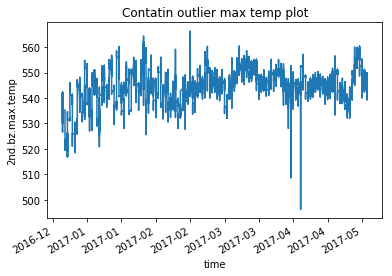

In [11]:
DrawTimePlot(date, max_2nd_bz, 'Contatin outlier max temp plot')

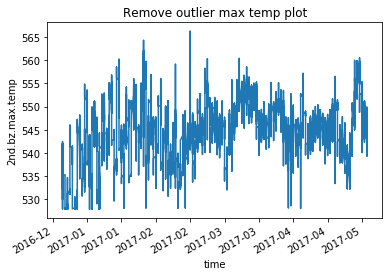

In [13]:
RTDB = RemoveLowerOut(RTDB,'max_2nd.Burning.Zone')

date = strtodate(RTDB.index)
max_2nd_bz = RTDB['max_2nd.Burning.Zone']

DrawTimePlot(date,max_2nd_bz, 'Remove outlier max temp plot')

In [14]:
total_value = pd.concat([RTDB.describe(),
           pd.DataFrame(RTDB.median()).T,
           RTDB.quantile([.01, .05, .1, .2, .99, .995, .999])]
         ).rename({0:'median', 0.01:'1%', 0.05:'5%', 0.1:'10%', 0.2:'20%', 0.99:'99%', 0.995:'99.5%', 0.999:'99.9%', }).sort_index()
total_value

,R1_RDT_Total_Feed,R1_RDT_PAR_FEED,R1_RDT_T_ARO,R1_RDT_T_PAR,R2_RDT_T_ARO,R2_RDT_T_PAR,R2_RDT_Total_Feed,R2_RDT_PAR_FEED,R3_RDT_Total_Feed,R3_RDT_T_ARO,...,ATMOSPHERE Burning Gas TEMP,H-4 INLET TEMPERATURE (R-4 RIT),H-3 OUT R-3 IN (R-3 RIT),H-2 OUT R-2 IN (R-2 RIT),H-1 OUT R-1 IN (R-1 RIT),R-4 OUT E-1 IN (R-4 ROT),R-3 OUT H-4 IN (R-3 ROT),R-2 OUT H-3 IN (R-2 ROT),R-1 OUT H-2 IN (R-1 ROT),Burning Gas concentration
1%,1.691592e+06,2.775521e+06,2.666221e+06,1.581477e+06,2.066940e+06,1.206620e+06,1.274217e+06,2.096303e+06,1.794613e+06,2.862051e+06,...,-6.200089,535.014500,533.188700,523.075400,518.218000,498.725900,480.425600,454.580700,405.600200,0.336131
10%,1.740362e+06,2.845170e+06,2.701452e+06,1.618645e+06,2.128363e+06,1.265522e+06,1.327943e+06,2.185832e+06,1.844202e+06,2.898629e+06,...,-1.809627,535.559400,535.112900,525.778100,519.830700,499.570100,482.021600,460.224300,412.558200,0.344143
20%,1.761243e+06,2.863792e+06,2.729724e+06,1.630543e+06,2.163396e+06,1.283017e+06,1.405293e+06,2.219356e+06,1.898950e+06,2.919522e+06,...,0.898956,536.026600,535.846900,527.034900,520.820400,500.133000,482.584900,460.694500,415.206700,0.346814
25%,1.766765e+06,2.869576e+06,2.746138e+06,1.634783e+06,2.176196e+06,1.287904e+06,1.417455e+06,2.233086e+06,1.903102e+06,2.932805e+06,...,2.002407,536.171100,536.302900,527.268400,521.443400,500.414400,482.866600,460.929600,415.868700,0.347577
5%,1.723852e+06,2.823173e+06,2.685086e+06,1.609114e+06,2.102561e+06,1.239670e+06,1.317215e+06,2.144151e+06,1.824386e+06,2.879525e+06,...,-3.657246,535.314800,534.779200,524.298800,519.063200,499.194900,481.505300,459.425000,411.280800,0.341091
50%,1.809521e+06,2.894230e+06,2.797101e+06,1.661745e+06,2.222681e+06,1.317543e+06,1.444373e+06,2.309051e+06,1.924725e+06,2.976957e+06,...,7.070290,537.383500,537.281600,528.636400,523.512000,501.915300,484.180800,462.622000,417.239700,0.351011
75%,1.831708e+06,2.925671e+06,2.848258e+06,1.680503e+06,2.269758e+06,1.339508e+06,1.465287e+06,2.360338e+06,1.947086e+06,3.020294e+06,...,13.070330,539.207500,539.350300,530.504900,524.056900,503.134600,485.260300,463.750100,418.137700,0.355971
99%,1.986265e+06,2.990360e+06,3.154617e+06,1.714513e+06,2.393469e+06,1.377484e+06,1.511438e+06,2.423169e+06,2.046210e+06,3.247936e+06,...,24.988871,540.597700,539.995400,532.473400,526.047800,504.588500,486.715200,465.912000,420.783900,0.367417
99.5%,1.990702e+06,3.000627e+06,3.169257e+06,1.718978e+06,2.404830e+06,1.388879e+06,1.512423e+06,2.436906e+06,2.049699e+06,3.261370e+06,...,26.061905,540.986900,540.251200,532.684800,526.170100,504.682200,486.856000,466.053100,420.972900,0.369325
99.9%,1.995496e+06,3.017743e+06,3.186611e+06,1.728105e+06,2.412143e+06,1.404803e+06,1.520856e+06,2.448664e+06,2.052307e+06,3.268321e+06,...,27.887792,542.602611,540.718300,533.196400,526.548300,504.916800,487.137500,466.335100,421.350800,0.378100


In [16]:
cor_coke = RTDB.corr().round(3)
cor_coke.to_csv(join(data_dir,'coke_cor.csv'))
print(cor_coke['max_2nd.Burning.Zone'][abs(cor_coke['max_2nd.Burning.Zone'])>0.3])
cor_coke

R4_RDT_T_ARO                     -0.495
max_2nd.Burning.Zone              1.000
max_2nd.1dan                      0.619
max_2nd.2dan                      0.614
max_2nd.3dan                      0.610
max_2nd.4dan                      0.631
max_2nd.5dan                      1.000
Catalyst_V3_front_coke Content    0.374
V-3 1ST BURN ZON H-1 OUTLET      -0.360
Burning Gas C-2 OUT TO V-3        0.714
Name: max_2nd.Burning.Zone, dtype: float64


,R1_RDT_Total_Feed,R1_RDT_PAR_FEED,R1_RDT_T_ARO,R1_RDT_T_PAR,R2_RDT_T_ARO,R2_RDT_T_PAR,R2_RDT_Total_Feed,R2_RDT_PAR_FEED,R3_RDT_Total_Feed,R3_RDT_T_ARO,...,ATMOSPHERE Burning Gas TEMP,H-4 INLET TEMPERATURE (R-4 RIT),H-3 OUT R-3 IN (R-3 RIT),H-2 OUT R-2 IN (R-2 RIT),H-1 OUT R-1 IN (R-1 RIT),R-4 OUT E-1 IN (R-4 ROT),R-3 OUT H-4 IN (R-3 ROT),R-2 OUT H-3 IN (R-2 ROT),R-1 OUT H-2 IN (R-1 ROT),Burning Gas concentration
R1_RDT_Total_Feed,1.000,0.083,0.799,0.096,0.663,-0.090,0.707,-0.086,0.673,0.470,...,0.220,0.244,0.258,0.138,0.163,0.301,0.072,-0.389,-0.707,-0.272
R1_RDT_PAR_FEED,0.083,1.000,0.145,0.631,0.378,0.635,0.290,0.652,0.212,0.253,...,-0.321,0.282,0.401,0.598,0.411,0.284,0.374,0.396,0.275,0.117
R1_RDT_T_ARO,0.799,0.145,1.000,0.321,0.633,-0.187,0.356,-0.254,0.374,0.650,...,-0.013,0.312,0.276,0.060,0.327,0.287,0.041,-0.339,-0.713,-0.328
R1_RDT_T_PAR,0.096,0.631,0.321,1.000,0.121,0.341,-0.062,0.088,0.157,0.402,...,-0.406,0.514,0.499,0.319,0.605,0.413,0.379,0.355,0.209,-0.053
R2_RDT_T_ARO,0.663,0.378,0.633,0.121,1.000,0.453,0.843,0.481,0.557,0.558,...,0.092,0.163,0.268,0.485,0.013,0.234,0.085,-0.234,-0.518,0.007
R2_RDT_T_PAR,-0.090,0.635,-0.187,0.341,0.453,1.000,0.461,0.909,0.272,0.096,...,-0.131,0.156,0.298,0.664,0.013,0.226,0.305,0.391,0.374,0.351
R2_RDT_Total_Feed,0.707,0.290,0.356,-0.062,0.843,0.461,1.000,0.554,0.717,0.287,...,0.280,0.076,0.204,0.483,-0.149,0.214,0.108,-0.220,-0.413,0.059
R2_RDT_PAR_FEED,-0.086,0.652,-0.254,0.088,0.481,0.909,0.554,1.000,0.255,-0.003,...,-0.045,-0.017,0.176,0.660,-0.115,0.091,0.226,0.315,0.328,0.367
R3_RDT_Total_Feed,0.673,0.212,0.374,0.157,0.557,0.272,0.717,0.255,1.000,0.633,...,0.096,0.406,0.422,0.302,0.024,0.343,0.128,-0.136,-0.301,-0.055
R3_RDT_T_ARO,0.470,0.253,0.650,0.402,0.558,0.096,0.287,-0.003,0.633,1.000,...,-0.222,0.510,0.456,0.204,0.288,0.290,0.054,-0.123,-0.358,-0.129


In [17]:
DrawTempPlt(RTDB['max_2nd.Burning.Zone'],RTDB)

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


![Burning%20Gas%20C-2%20OUT%20TO%20V-3%20vs%20max_2nd.Burning.Zone.png](attachment:Burning%20Gas%20C-2%20OUT%20TO%20V-3%20vs%20max_2nd.Burning.Zone.png)

In [34]:
DrawDanTempPlt(RTDB)

max_2nd.1dan


C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


max_2nd.2dan
max_2nd.3dan
max_2nd.4dan
max_2nd.5dan


![R4_RDT_T_ARO%20vs%20max_2nd.5dan.png](attachment:R4_RDT_T_ARO%20vs%20max_2nd.5dan.png)

In [18]:
idx_RTDB = RTDB.reset_index() # Remove NaN row


x_RTDB = idx_RTDB.drop(['max_2nd.Burning.Zone', 'max_2nd.1dan', 'max_2nd.2dan', 
                         'max_2nd.3dan', 'max_2nd.4dan', 'max_2nd.5dan', 'index'],1)
idx_RTDB = idx_RTDB.drop(['max_2nd.1dan', 'max_2nd.2dan', 
                         'max_2nd.3dan', 'max_2nd.4dan', 'max_2nd.5dan', 'index'],1)

x_RTDB = x_RTDB[:len(x_RTDB)-120]
idx_RTDB = idx_RTDB[:len(idx_RTDB)-120]

train_x = x_RTDB.loc[1:(len(idx_RTDB)*4/5)]
train_y = idx_RTDB.loc[1:(len(idx_RTDB)*4/5),['max_2nd.Burning.Zone']]

test_x = x_RTDB.loc[(len(idx_RTDB)*4/5):]
test_y = idx_RTDB.loc[(len(idx_RTDB)*4/5):, ['max_2nd.Burning.Zone']]

short_x = x_RTDB.loc[1:(len(idx_RTDB)*1/5)]
short_y = idx_RTDB.loc[1:(len(idx_RTDB)*1/5),['max_2nd.Burning.Zone']]

short_x_t = x_RTDB.loc[(len(idx_RTDB)*1/5):(len(idx_RTDB)*6/25)]
short_y_t = idx_RTDB.loc[(len(idx_RTDB)*1/5):(len(idx_RTDB)*6/25),['max_2nd.Burning.Zone']]

dnn_train_x = idx_RTDB.loc[:(len(idx_RTDB)*4/5)]
dnn_train_x.columns = [col.replace(' ', '_') for col in dnn_train_x.columns]
dnn_train_y = idx_RTDB.loc[(len(idx_RTDB)*4/5):]
dnn_train_y.columns = [col.replace(' ', '_') for col in dnn_train_x.columns]

train_y_label = pd.DataFrame(train_y['max_2nd.Burning.Zone'].apply(lambda x: 1 if x >=550 else 0))
test_y_label = pd.DataFrame(test_y['max_2nd.Burning.Zone'].apply(lambda x: 1 if x >=550 else 0))
short_y_label = pd.DataFrame(short_y['max_2nd.Burning.Zone'].apply(lambda x: 1 if x >=550 else 0))

# SHORT TRAINING

SelectKBest 변수 선택

In [19]:
clf = SelectKBest( k=17)
short_X_features = clf.fit(short_x,short_y)
print(short_x.columns.values[short_X_features.get_support()])

short_x = short_x[short_x.columns.values[short_X_features.get_support()]]
short_x_t = short_x_t[short_x_t.columns.values[short_X_features.get_support()]]

['R1_RDT_Total_Feed' 'R2_RDT_Total_Feed' 'R3_RDT_Total_Feed' 'R3_RDT_T_ARO'
 'R3_RDT_PAR_FEED' 'R3_RDT_T_PAR' 'R3_RIT_mean' 'R3_RIT_max' 'C_1_DISCH'
 'R2_New_Wait' 'R3_New_Wait' 'R4_New_Wait' 'V-3 1ST BURN ZON H-1 OUTLET'
 'Burning Gas C-2 OUT TO V-3' 'ATMOSPHERE Burning Gas TEMP'
 'R-4 OUT E-1 IN (R-4 ROT)' 'R-3 OUT H-4 IN (R-3 ROT)']


C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [20]:
scaler = preprocessing.StandardScaler().fit(short_x)
scale_short = scaler.transform(short_x) 
scale_short_t = scaler.transform(short_x_t)

In [14]:
estimator = SVR(kernel="linear", verbose=True)
selector = RFECV(estimator, step=1, cv=2, verbose=10)
selector = selector.fit(scale_short, short_y)
selector.support_ 

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 51 features.
[LibSVM]Fitting estimator with 50 features.
[LibSVM]Fitting estimator with 49 features.
[LibSVM]Fitting estimator with 48 features.
[LibSVM]Fitting estimator with 47 features.
[LibSVM]Fitting estimator with 46 features.
[LibSVM]Fitting estimator with 45 features.
[LibSVM]Fitting estimator with 44 features.
[LibSVM]Fitting estimator with 43 features.
[LibSVM]Fitting estimator with 42 features.
[LibSVM]Fitting estimator with 41 features.
[LibSVM]Fitting estimator with 40 features.
[LibSVM]Fitting estimator with 39 features.
[LibSVM]Fitting estimator with 38 features.
[LibSVM]Fitting estimator with 37 features.
[LibSVM]Fitting estimator with 36 features.
[LibSVM]Fitting estimator with 35 features.
[LibSVM]Fitting estimator with 34 features.
[LibSVM]Fitting estimator with 33 features.
[LibSVM]Fitting estimator with 32 features.
[LibSVM]Fitting estimator with 31 features.
[LibSVM]Fitting estimator with 30 features.
[LibSVM]Fitting estimator with 29 featur

array([ True, False, False, False,  True, False, False,  True, False,
       False,  True,  True,  True,  True,  True, False, False, False,
        True,  True, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False,  True,  True, False, False, False,
       False, False, False, False, False, False], dtype=bool)

SelectKBest SVR

In [28]:
start_time = tm.time()
svr_short = SVR('rbf', verbose=True)

svr_short.fit(scale_short,short_y['max_2nd.Burning.Zone'])
print("svr classification termination %s seconds ---" % (tm.time() - start_time))

[LibSVM]svr classification termination 69.5009753704071 seconds ---


In [38]:
prediction = svr_short.predict(scale_short_t)
real = short_y_t['max_2nd.Burning.Zone']
score = svr_short.score(scale_short_t, real)
print(prediction)
print(score)
RMSE = mean_squared_error(real, prediction)**0.5
print(RMSE)

[ 550.59713067  548.88455384  549.33719124 ...,  537.08318387  536.32619716
  535.83964954]
-6.01010823233
11.1462058521


# REAL TRAINING

In [36]:
start_time = tm.time()
clf = SelectKBest( k=17)
X_features = clf.fit(train_x,train_y)
train_x = train_x[train_x.columns.values[X_features.get_support()]]
test_x = test_x[test_x.columns.values[X_features.get_support()]]
print("SelectKBest feature selection F-test %s seconds ---" % (tm.time() - start_time))

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SelectKBest feature selection F-test 0.24401402473449707 seconds ---


In [18]:
scaler = preprocessing.StandardScaler().fit(train_x)
scale_train = scaler.transform(train_x) 
scale_test = scaler.transform(test_x)

In [ ]:
estimator_rfe = SVR(kernel="linear", verbose=True)
selector_rfe = RFECV(estimator_rfe, step=1, cv=StratifiedKFold(3), verbose=10)
selector_rfe = selector.fit(scale_train, train_y)
selector_rfe.support_ 

with open('real_rfecv.pkl', 'wb') as fid:
    cPickle.dump(selector_rfe, fid)

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 51 features.
[LibSVM]

In [40]:
start_time = tm.time()
svr = SVR('rbf', verbose=True)

svr.fit(scale_train, train_y['max_2nd.Burning.Zone'])
print("svr classification termination %s seconds ---" % (tm.time() - start_time))

[LibSVM]svr classification termination 287.6014497280121 seconds ---


In [49]:
prediction = svr.predict(scale_test)
real = test_y['max_2nd.Burning.Zone']
score = svr.score(scale_test, real)
print(prediction)
print(score)
RMSE = mean_squared_error(real, prediction)**0.5
print(RMSE)

[ 541.12835732  541.53116878  542.08756842 ...,  535.87697983  536.20268349
  536.44582562]
-6.01010823233
4.4474098001
